In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#IMPORTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [3]:
loc = 'nw2'
turbine = 'c02'

# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.getcwd()))
data_folder = os.path.join(package_folder, 'data')
SS2_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_SS2_mode.parquet'))
ss2_selected = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_large.csv'))
ss2_selected.set_index('timestamp', inplace=True)
ss2_selected.index = pd.to_datetime(ss2_selected.index)
rfe_selected_data = pd.read_parquet(os.path.join(data_folder, 'interim', loc, 'rfe_selected_data', loc+turbine+'_rfe_selected_data.parquet'))

from src.data.utils import get_input_data
from src.data.harmonics import *

data = get_input_data(data_folder, loc, turbine)
harmonics_data = harmonics(data['turbine_data'].filter(regex='rpm'), [1,3,6, 9])

test_data_path = '_'.join([loc, turbine, 'SS2', 'test_data.parquet'])
test_turbine_data = pd.read_parquet(os.path.join(data_folder, 'raw', loc, test_data_path))
#remove duplicated index
duplicated_indices = test_turbine_data.index.duplicated(keep='first')
test_turbine_data = test_turbine_data[~duplicated_indices]
test_turbine_data.index = pd.to_datetime(test_turbine_data.index, utc=True)

wandelaar_weather_station_data = pd.read_parquet(os.path.join(data_folder,'external', loc, 'test_wandelaar_weather_data.parquet'))
westhinder_weather_station_data = pd.read_parquet(os.path.join(data_folder,'external', loc, 'test_westhinder_weather_data.parquet'))

mvbc_test_data = wandelaar_weather_station_data.copy()
mvbc_test_data[mvbc_test_data.filter(regex='Tide').columns] = westhinder_weather_station_data.filter(regex='Tide').values
#mvbc_test_data.rename(columns={mvbc_test_data.filter(regex='Tide').columns[0] :westhinder_weather_station_data.filter(regex='Tide').columns[0]}, inplace=True)
mvbc_test_data.isna().sum()
mvbc_test_data.index = pd.to_datetime(mvbc_test_data.index, utc=True)


mvbc_data = pd.concat([data['mvbc_data'], mvbc_test_data], axis=0)
mvbc_data = mvbc_data[~mvbc_data.index.duplicated(keep='first')]

scada_data = data['turbine_data'].filter(regex='mean_').filter(regex='rpm|yaw|pitch|power|windspeed|winddirection')

In [4]:
X_ = pd.concat([mvbc_data, scada_data], axis=1)
#only keep columns of X with 90% or more non-nan values
X_ = X_.loc[:, X_.isna().sum()/len(X_) < 0.1]

y_ = SS2_dbscan['mean_damping']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Xy = pd.DataFrame(y_)
for col in X_.columns:
    Xy[col] = X_[col]
Xy = Xy.dropna()
y = Xy[y_.name]
X = Xy[X_.columns]

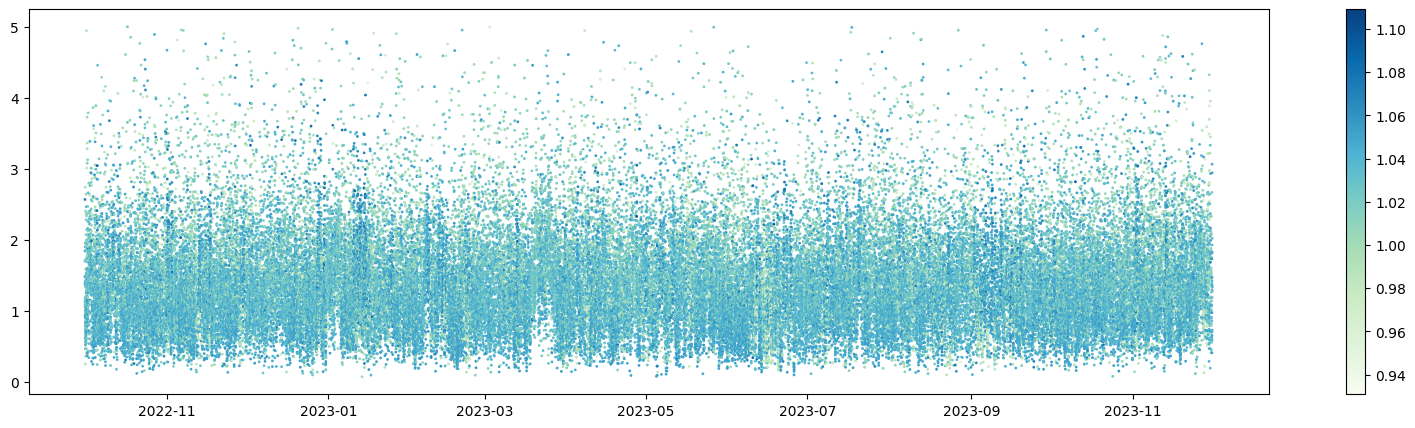

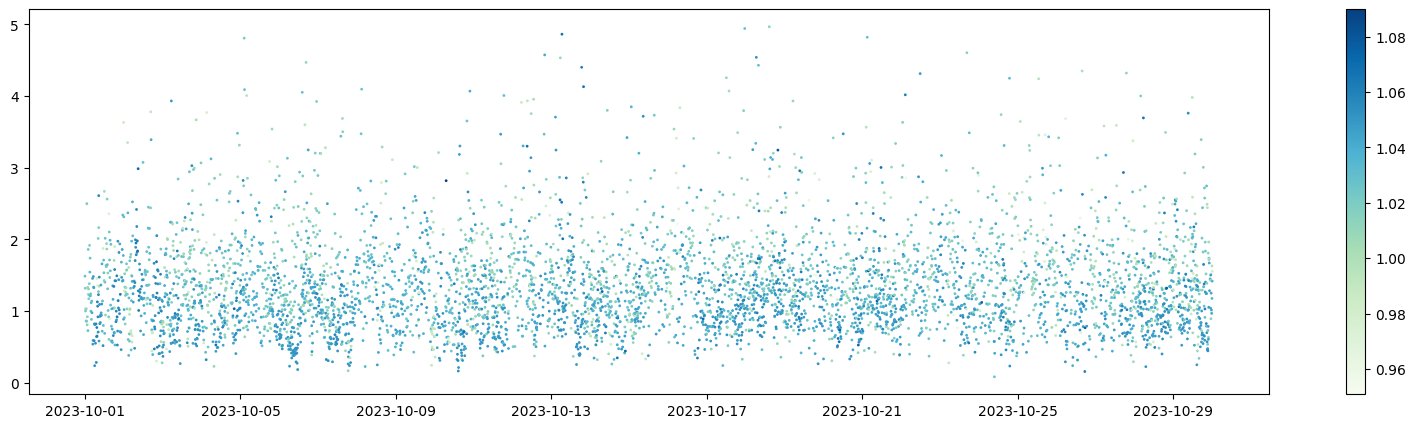

In [34]:
SS2_dbscan_low_damping = SS2_dbscan[SS2_dbscan['mean_damping'] < 5]
plt.figure(figsize=(20,5))
plt.scatter(SS2_dbscan_low_damping.index, SS2_dbscan_low_damping['mean_damping'], c=SS2_dbscan_low_damping['mean_frequency'], cmap='GnBu', s=1)
plt.colorbar()
plt.show()
plt.close()

#short time-period
start = datetime.datetime(2023, 10, 1, tzinfo=datetime.timezone.utc)
end = datetime.datetime(2023, 10, 30, tzinfo=datetime.timezone.utc)
plt.figure(figsize=(20,5))
plt.scatter(SS2_dbscan_low_damping.loc[start:end].index, SS2_dbscan_low_damping['mean_damping'].loc[start:end], c=SS2_dbscan_low_damping['mean_frequency'].loc[start:end], cmap='GnBu', s=1)
plt.colorbar()
plt.show()
plt.close()

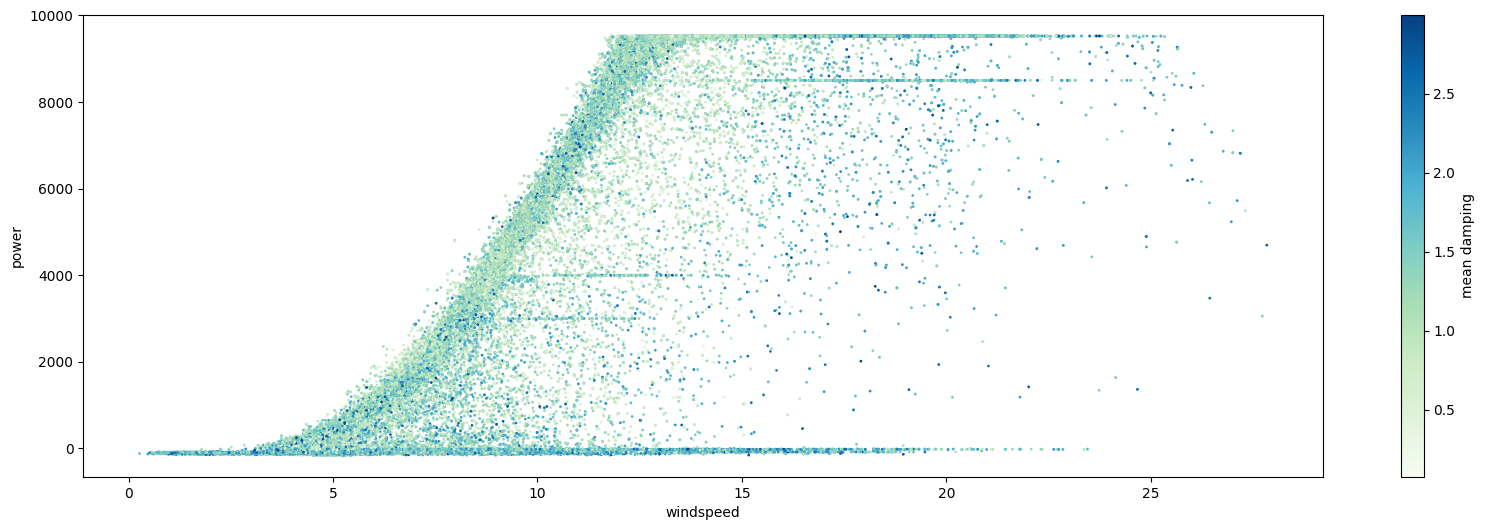

In [30]:
SS2_dbscan_low_damping = SS2_dbscan[SS2_dbscan['mean_damping'] < 3]
X_low_damping = pd.DataFrame(index=SS2_dbscan_low_damping.index)
for col in X_.columns:
    X_low_damping[col] = X_[col]

plt.figure(figsize=(20,6))
plt.scatter(X_low_damping.filter(regex='windspeed'), X_low_damping.filter(regex='power'), c=SS2_dbscan_low_damping['mean_damping'], cmap='GnBu', s=1)
plt.xlabel('windspeed')
plt.ylabel('power')
cbar = plt.colorbar()
cbar.set_label('mean damping')

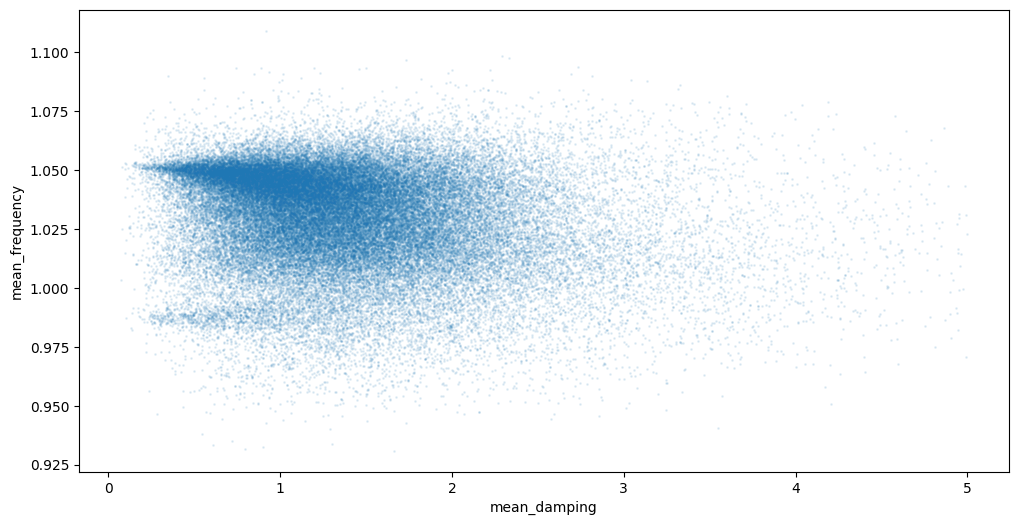

In [6]:
plt.figure(figsize=(12,6))
plt.scatter(SS2_dbscan['mean_damping'], SS2_dbscan['mean_frequency'],s=1, alpha=0.1)
plt.xlabel('mean_damping')
plt.ylabel('mean_frequency')
plt.show()

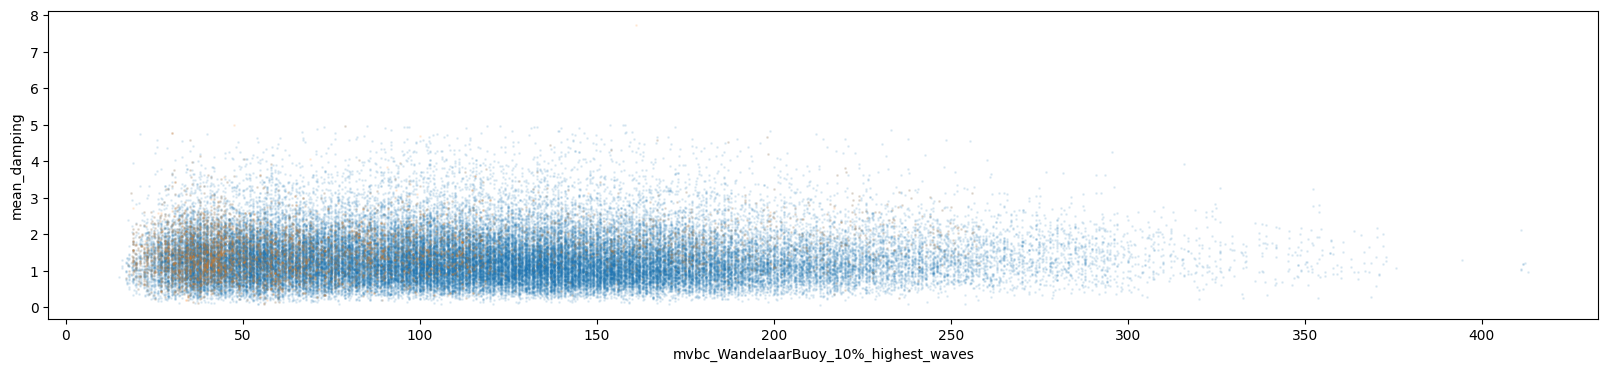

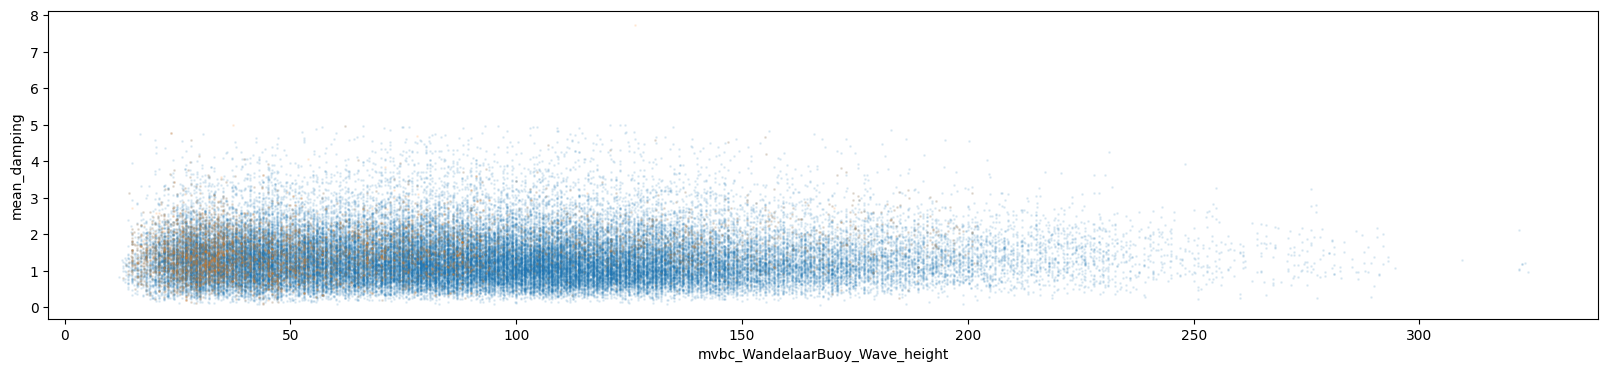

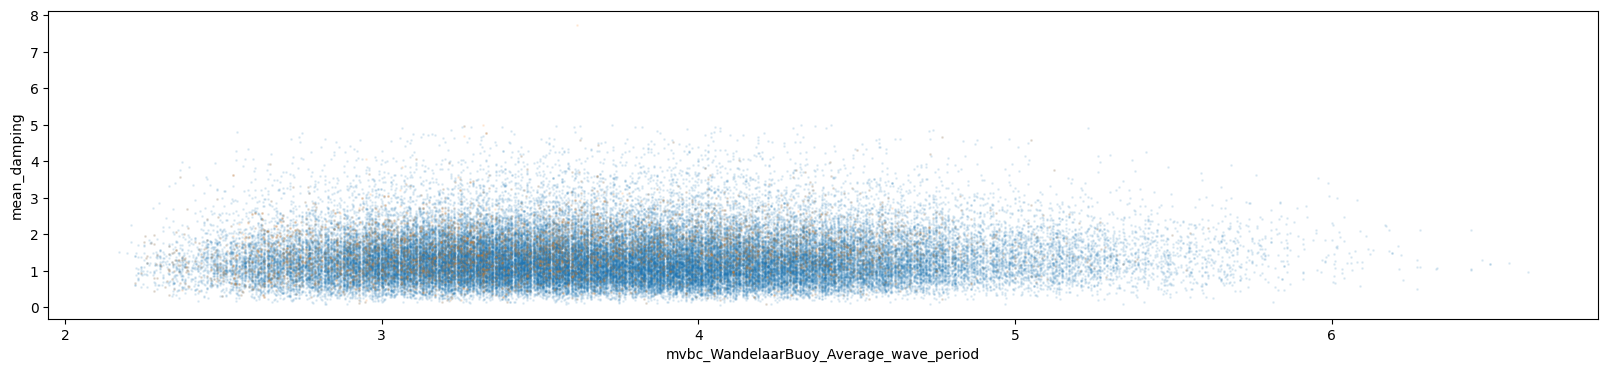

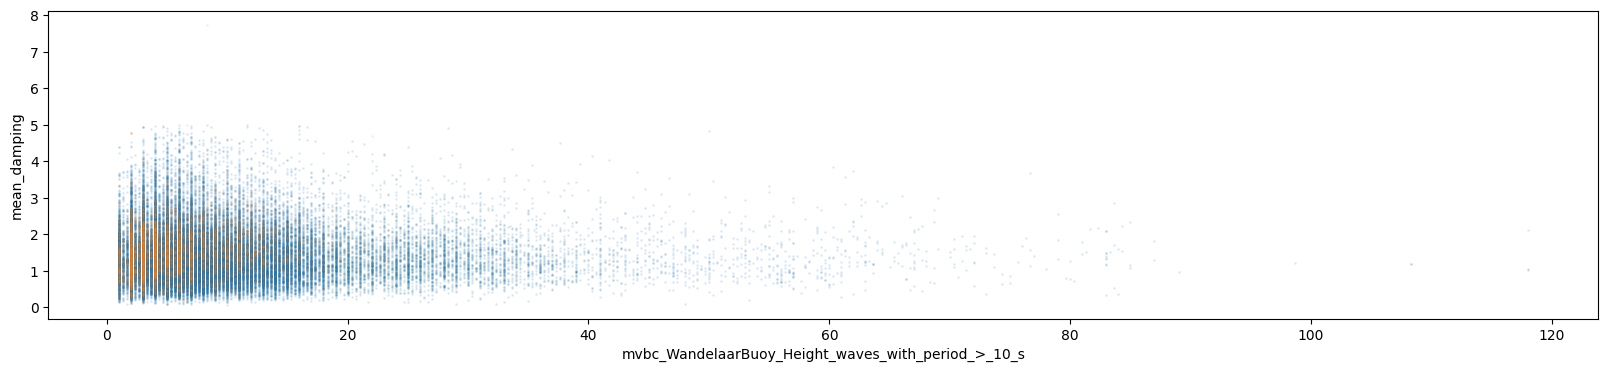

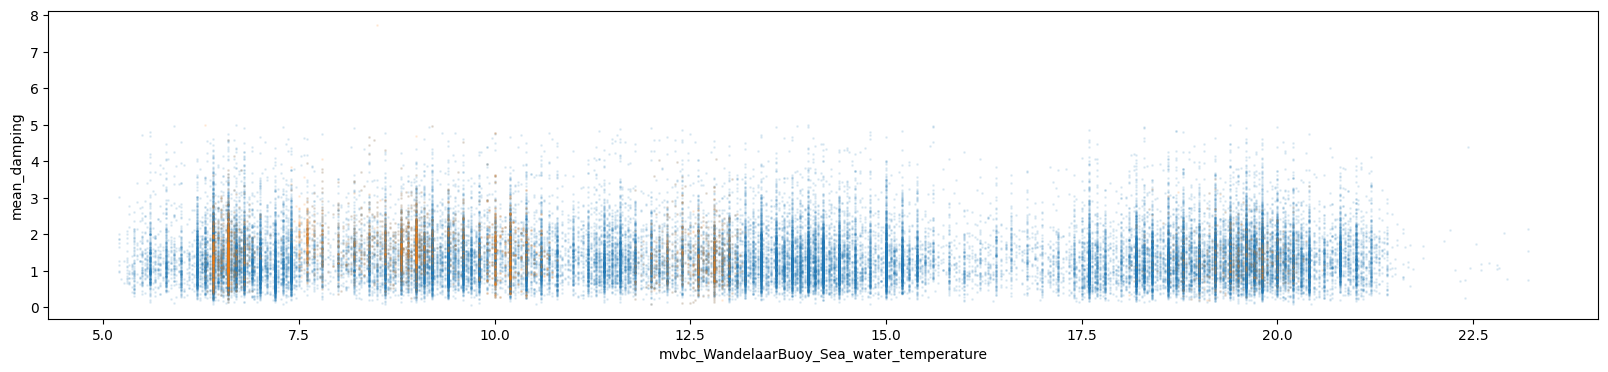

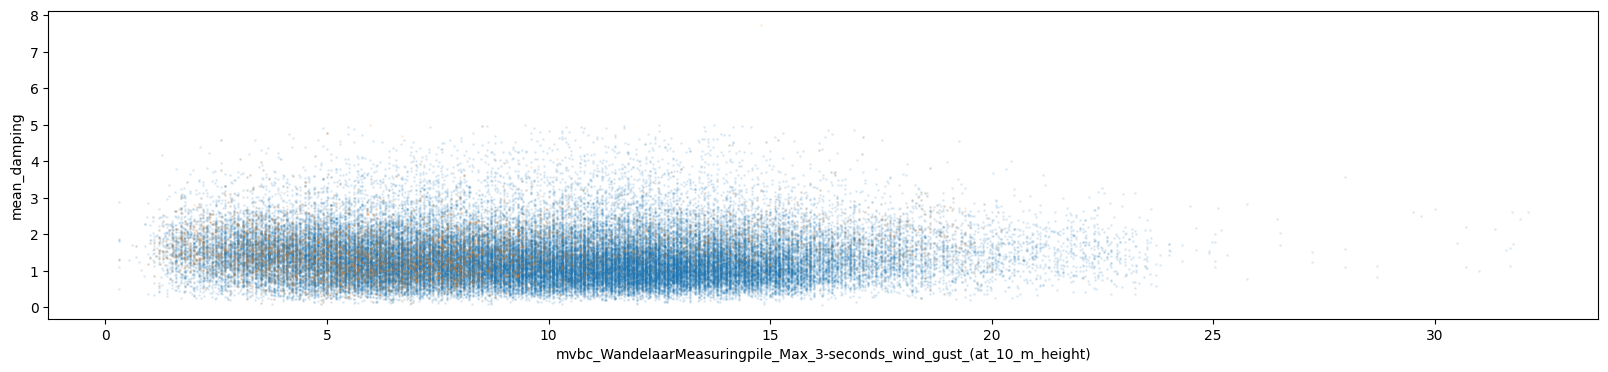

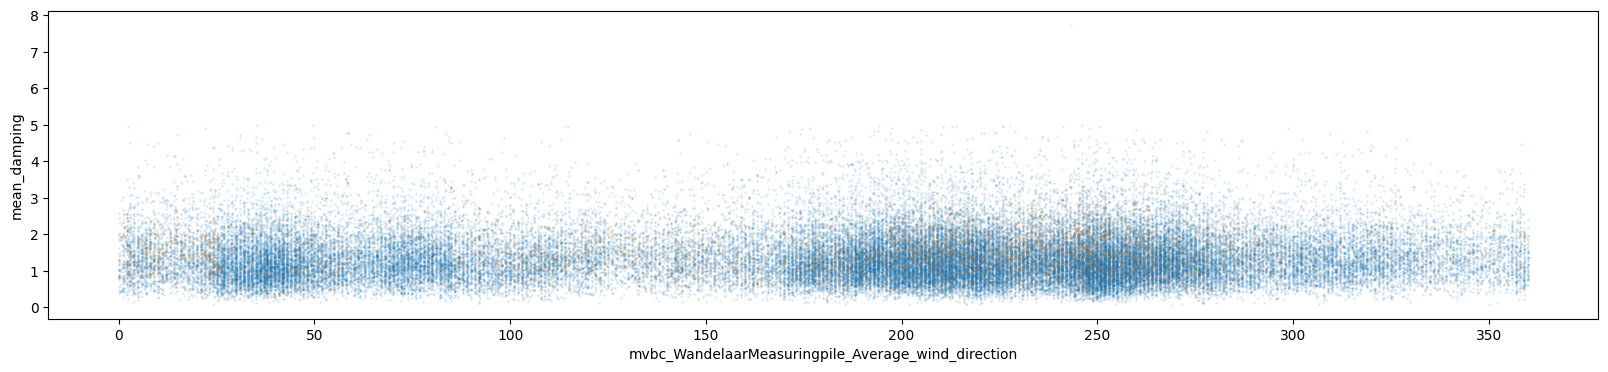

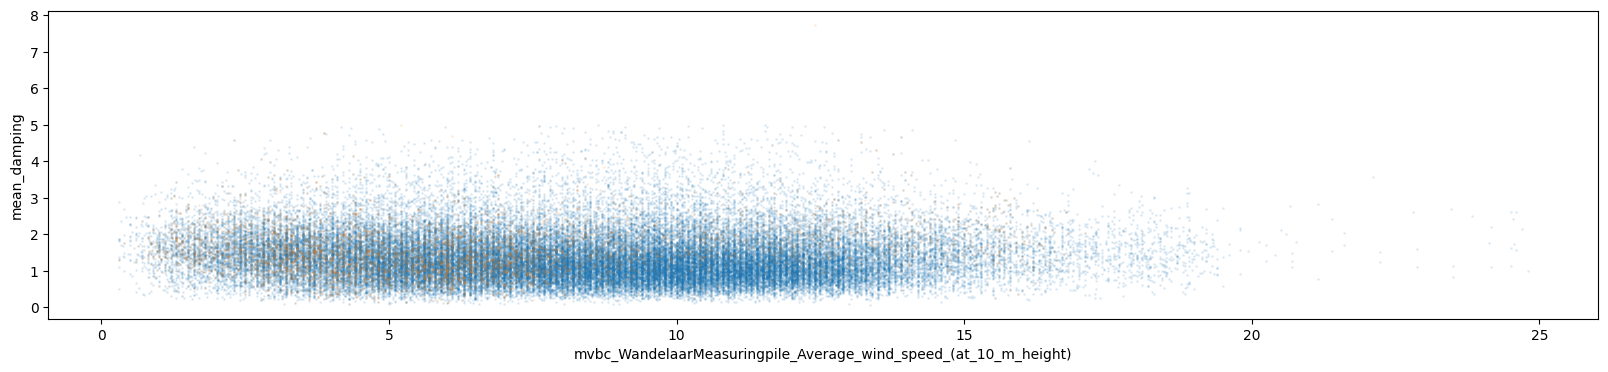

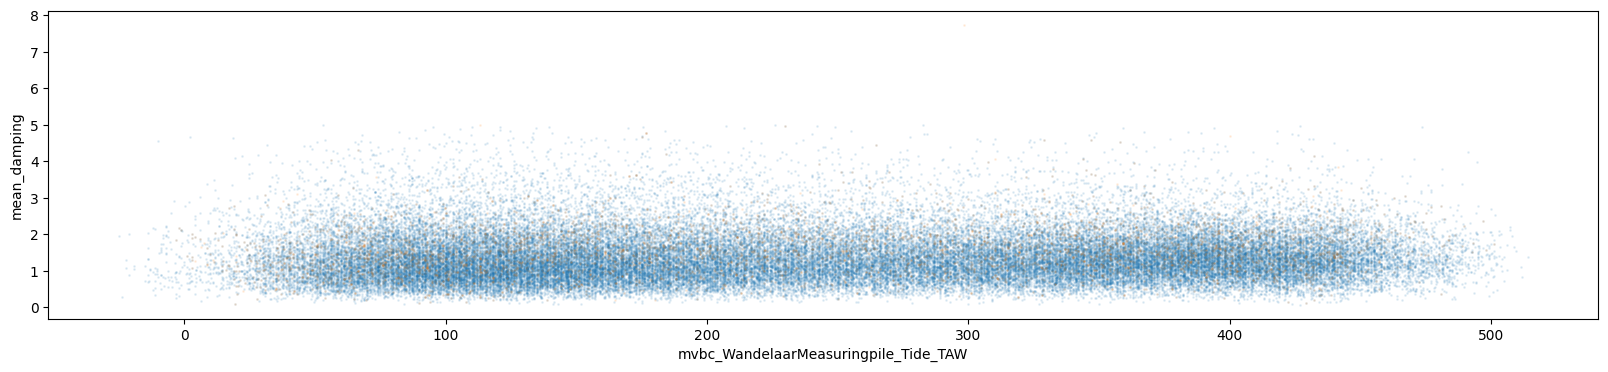

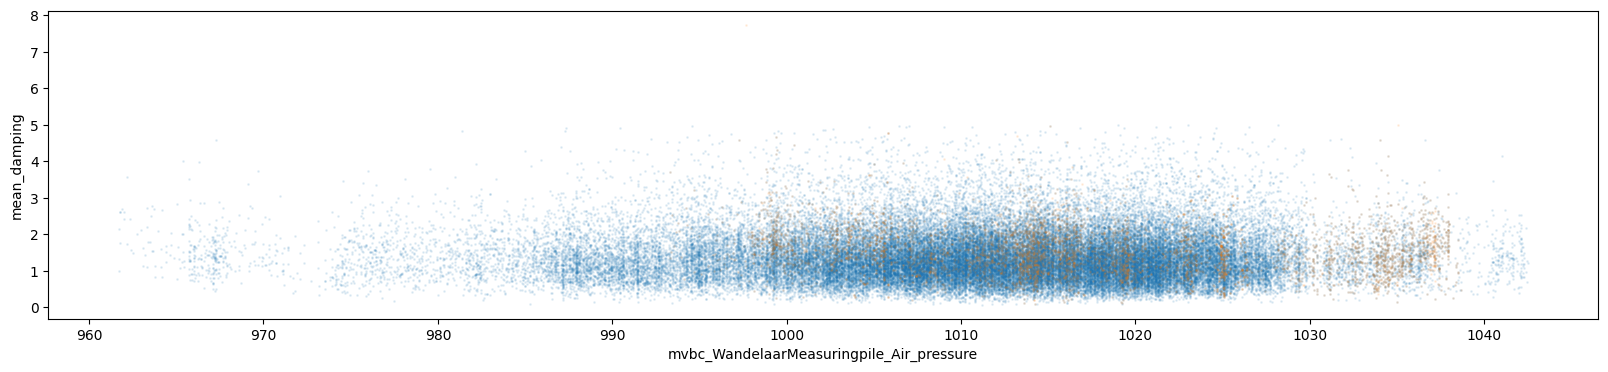

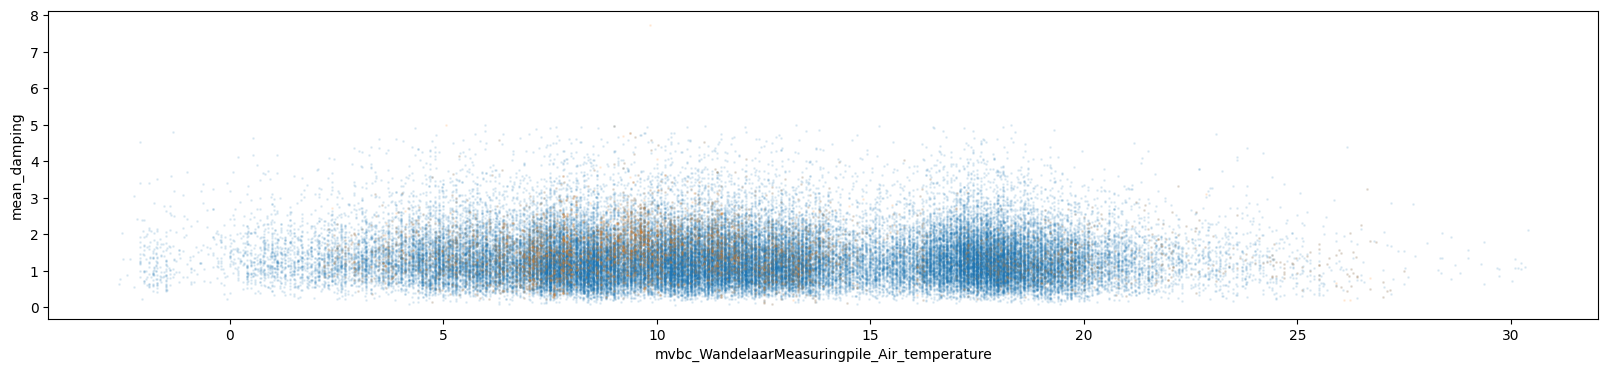

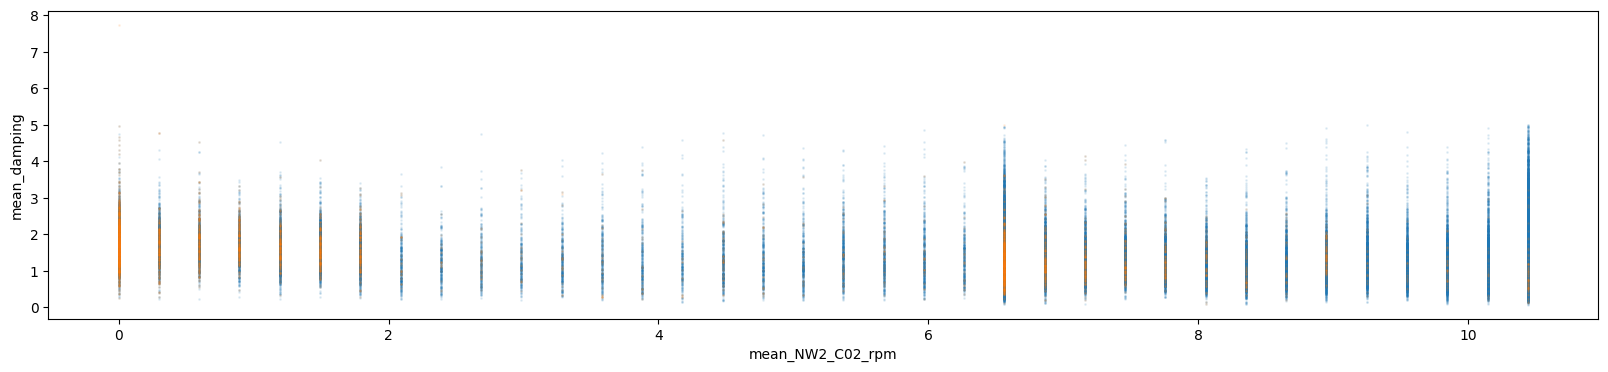

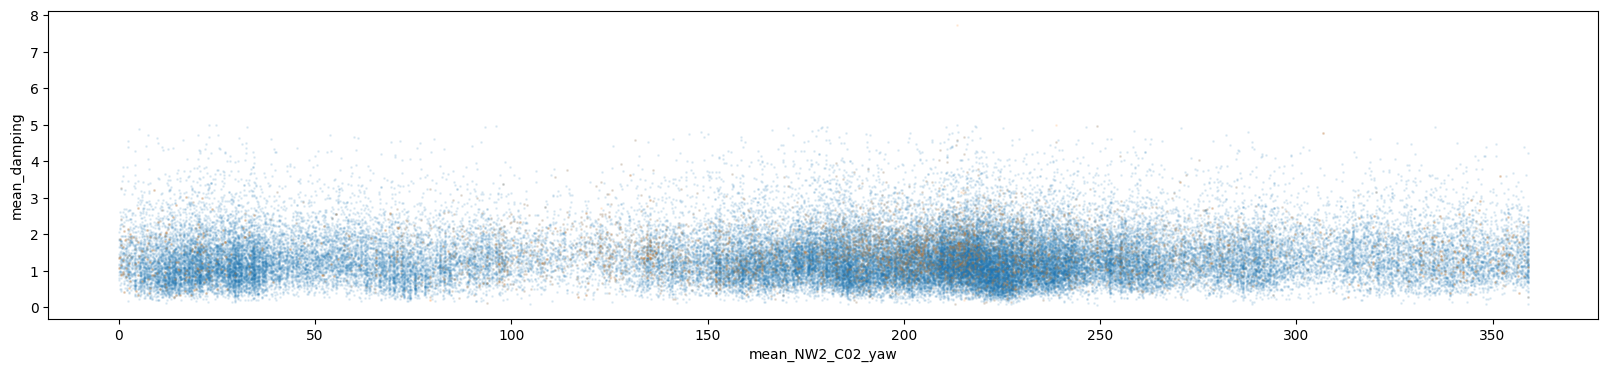

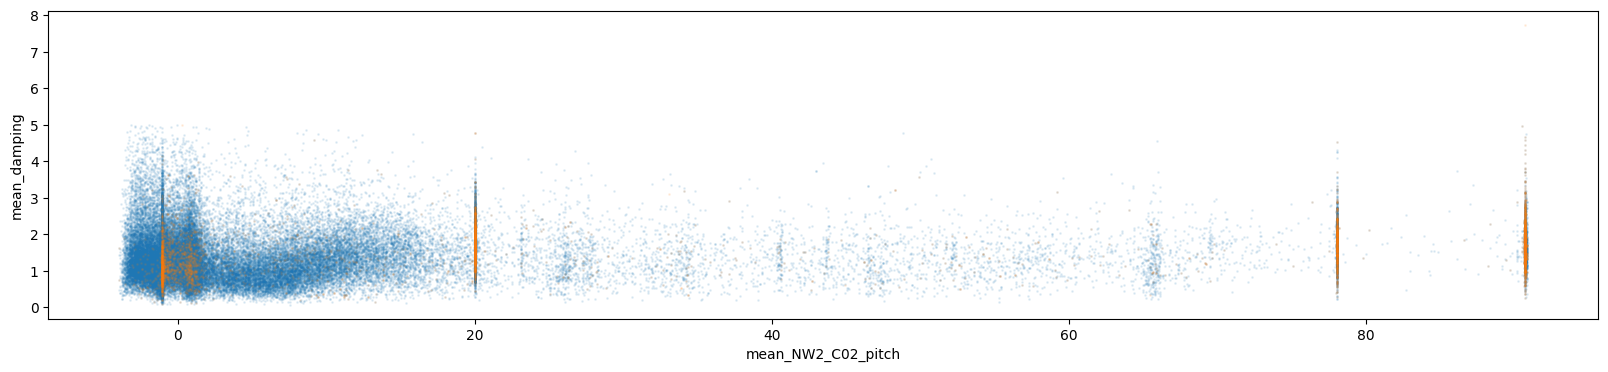

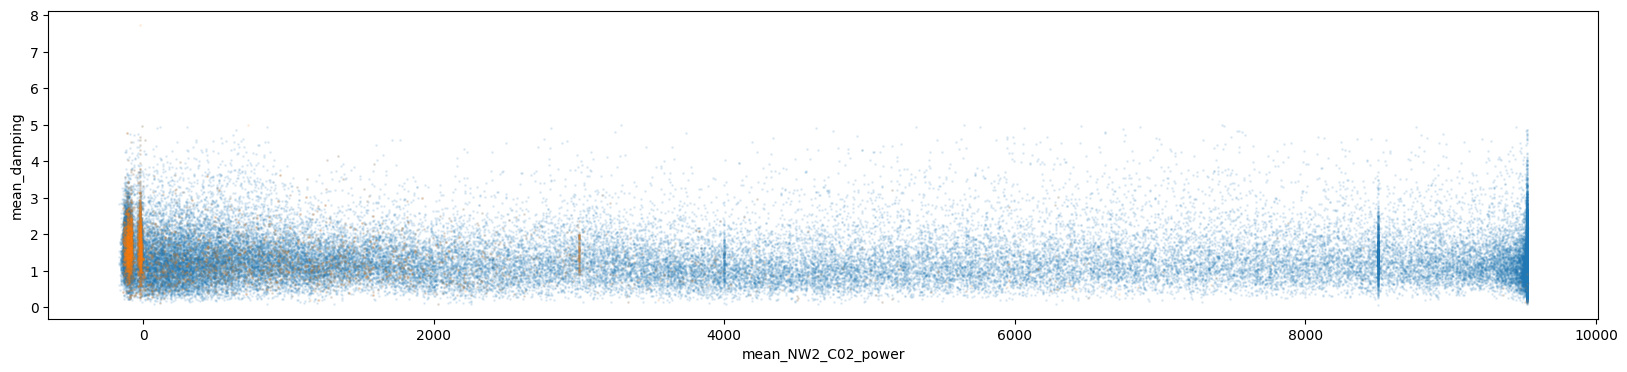

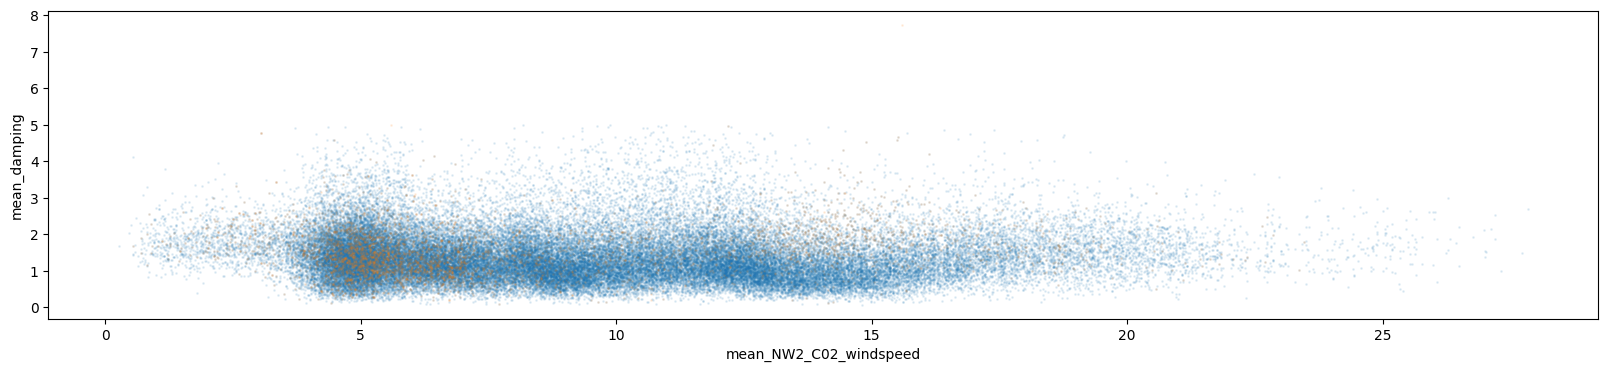

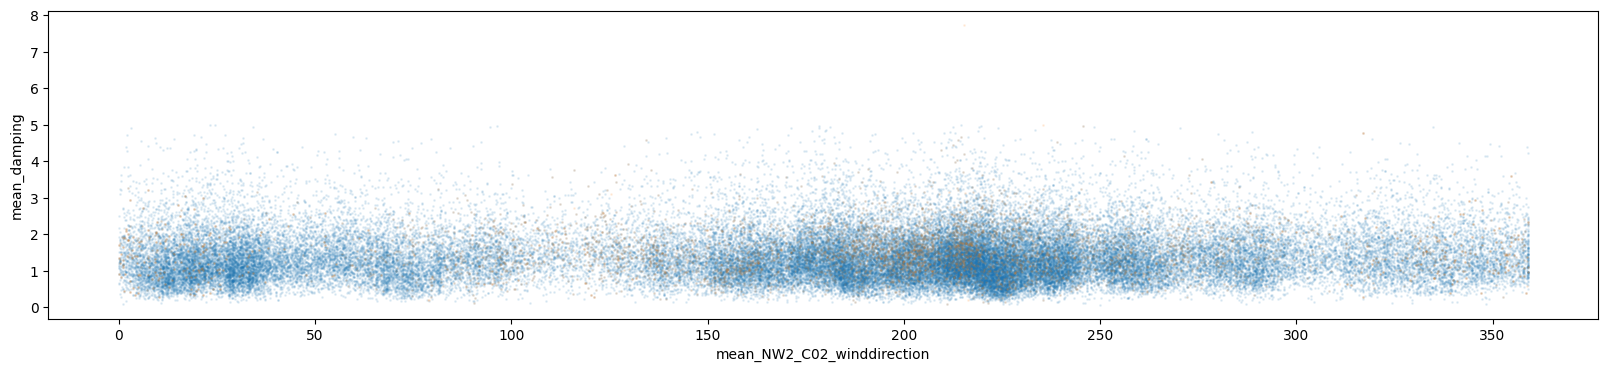

In [24]:
X_ = pd.concat([mvbc_data, scada_data], axis=1)
#only keep columns of X with 90% or more non-nan values
X_ = X_.loc[:, X_.isna().sum()/len(X_) < 0.1]

X_selected = pd.DataFrame(index = ss2_selected.index)

for col in X_:
    X_selected[col] = X_[col]

for col in X.columns:
    plt.figure(figsize=(20,4))
    plt.scatter(X[col], y,s=1, alpha=0.1)
    plt.scatter(X_selected[col], ss2_selected['mean_damping'],s=1, alpha=0.1)
    plt.xlabel(col)
    plt.ylabel(y.name)
    plt.show()

Availability:  0.917466786209145
Selected features: Index(['mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_C02_rpm',
       'mean_NW2_C02_yaw', 'mean_NW2_C02_pitch', 'mean_NW2_C02_power',
       'mean_NW2_C02_windspeed', 'mean_NW2_C02_winddirection'],
      dtype='object')
Removed features:  Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Air_pressure'],
      dtype='object')
Feature ranking: [9 1 7 8 3 4 5 6 1 2 1 1 1 1 1 1 1]
ordered features:  Index(['mvbc_WandelaarMeasuringpile_Tide_T

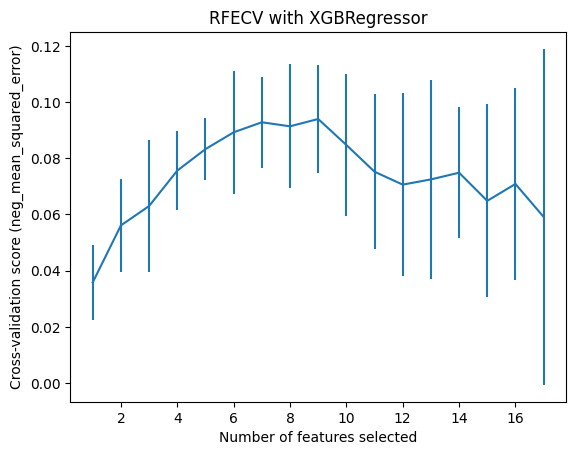

In [8]:
from sklearn.model_selection import train_test_split
X_ = pd.concat([mvbc_data, scada_data], axis=1)
#only keep columns of X with 90% or more non-nan values
X_ = X_.loc[:, X_.isna().sum()/len(X_) < 0.1]

y_ = SS2_dbscan['mean_damping']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Xy = pd.DataFrame(y_)
for col in X_.columns:
    Xy[col] = X_[col]
Xy = Xy.dropna()
y = Xy[y_.name]
X = Xy[X_.columns]

y_unique = y_[~y_.index.duplicated(keep='first')].dropna()
print('Availability: ', len(y_unique)/len(X_))

from xgboost import XGBRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, KFold

regr_model = XGBRegressor()
cv = KFold(10)
selector = RFECV(
    regr_model,
    step=1,
    cv=cv,
    scoring="r2",
    min_features_to_select=1,
    n_jobs=2,
)
selector = selector.fit(X, y)

selected_features = selector.support_
ranking = selector.ranking_

print("Selected features:", X.columns[selected_features])
print("Removed features: ", X.columns[~selected_features])
print("Feature ranking:", ranking)
print('ordered features: ', X.columns[ranking.argsort()])

import matplotlib.pyplot as plt

# Assuming 'selector' is your RFECV object
n_scores = len(selector.cv_results_["mean_test_score"])
min_features_to_select = 1  # as defined in your RFECV setup

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (neg_mean_squared_error)")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    selector.cv_results_["mean_test_score"],
    yerr=selector.cv_results_["std_test_score"] if 'std_test_score' in selector.cv_results_ else None
)
plt.title("RFECV with XGBRegressor")
plt.show()

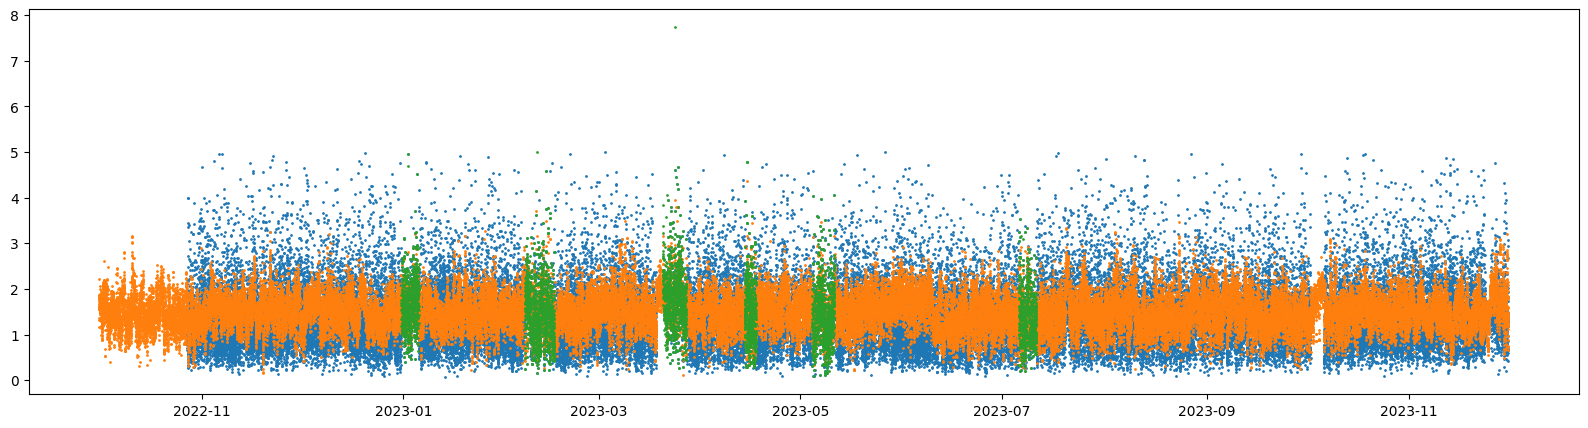

In [12]:
from sklearn.model_selection import train_test_split
X_ = X[X.columns[selected_features]]

X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=42)

X_ = pd.concat([mvbc_data, scada_data], axis=1)
#only keep columns of X with 90% or more non-nan values
X_ = X_.loc[:, X_.isna().sum()/len(X_) < 0.1]
X_ = X_[X_.columns[selected_features]]

X_selected = pd.DataFrame(index = ss2_selected.index)

for col in X_:
    X_selected[col] = X_[col]

xgb_regr = XGBRegressor()
xgb_regr.fit(X_selected, ss2_selected['mean_damping'])
xgb_pred = xgb_regr.predict(X_)

from catboost import CatBoostRegressor
cat_regr = CatBoostRegressor(posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
cat_regr.fit(X_selected, ss2_selected['mean_damping'])
cat_pred = cat_regr.predict(X_)
cat_pred_df = pd.DataFrame(cat_pred, columns=['prediction', 'spread'], index=X_.index)
cat_pred_virtual = cat_regr.virtual_ensembles_predict(X_, prediction_type='TotalUncertainty', virtual_ensembles_count=50, ntree_end=200)
cat_pred_virtual_df = pd.DataFrame(cat_pred_virtual, columns=['prediction', 'knowledge_uncertainty', 'data_uncertainty'], index=X_.index)

plt.figure(figsize=(20,5))
plt.scatter(y.index, y, s=1, alpha=1.0)
plt.scatter(X_.index, xgb_pred, s=1, alpha=1.0)
plt.scatter(ss2_selected.index, ss2_selected['mean_damping'], s=1, alpha=1.0)
plt.show()


In [40]:
uncertainty_ = pd.Series(cat_pred_virtual_df['knowledge_uncertainty'], index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()
uncertainty_lim = uncertainty_moving_avg.loc[X_train.index].quantile(0.8)

prediction_lim = (y - cat_pred_df['prediction']).loc[X_train.index].std()*3

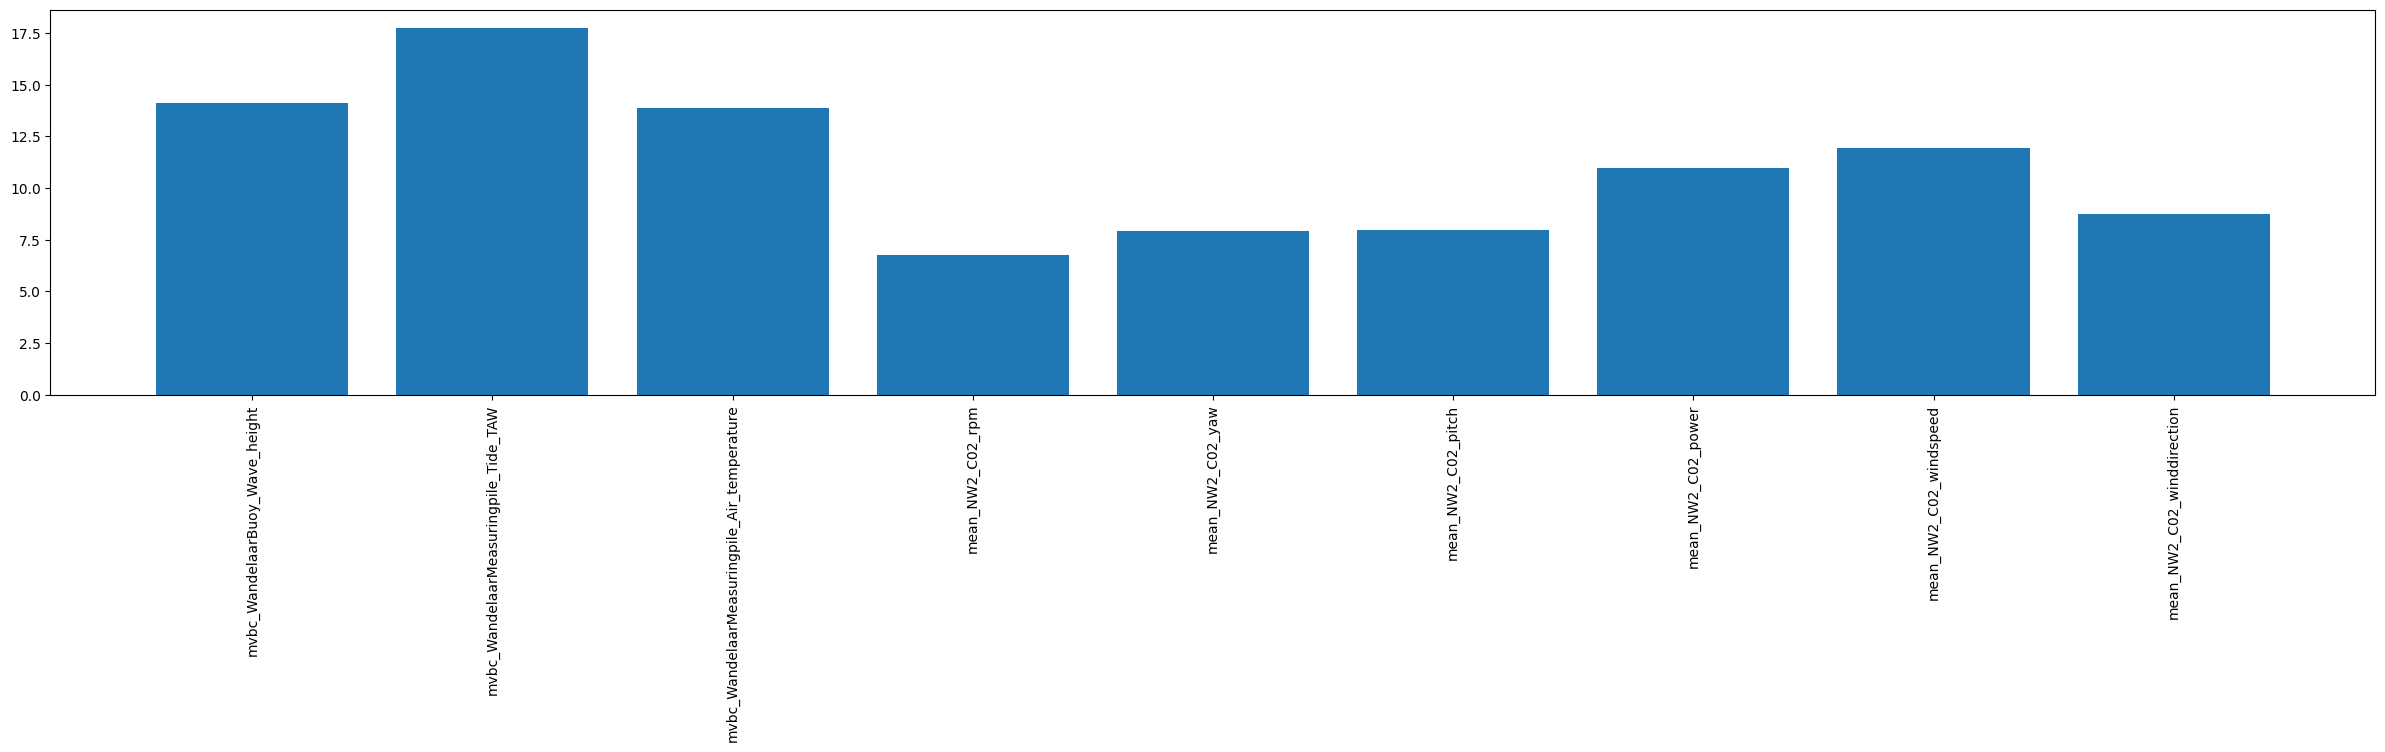

In [41]:
plt.figure(figsize=(30,5))
plt.bar(cat_regr.feature_names_, cat_regr.feature_importances_)
plt.xticks(rotation=90)
plt.show()
plt.close()

In [42]:
from src.smart_tracking.smart_tracking import smart_tracking

smart_tracked_modes = smart_tracking(y, cat_pred_df['prediction'], uncertainty_moving_avg, uncertainty_lim, prediction_lim)

C:\Users\Max\AppData\Local\Temp\ipykernel_15024\3263405331.py:37: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handles in legend.legendHandles:


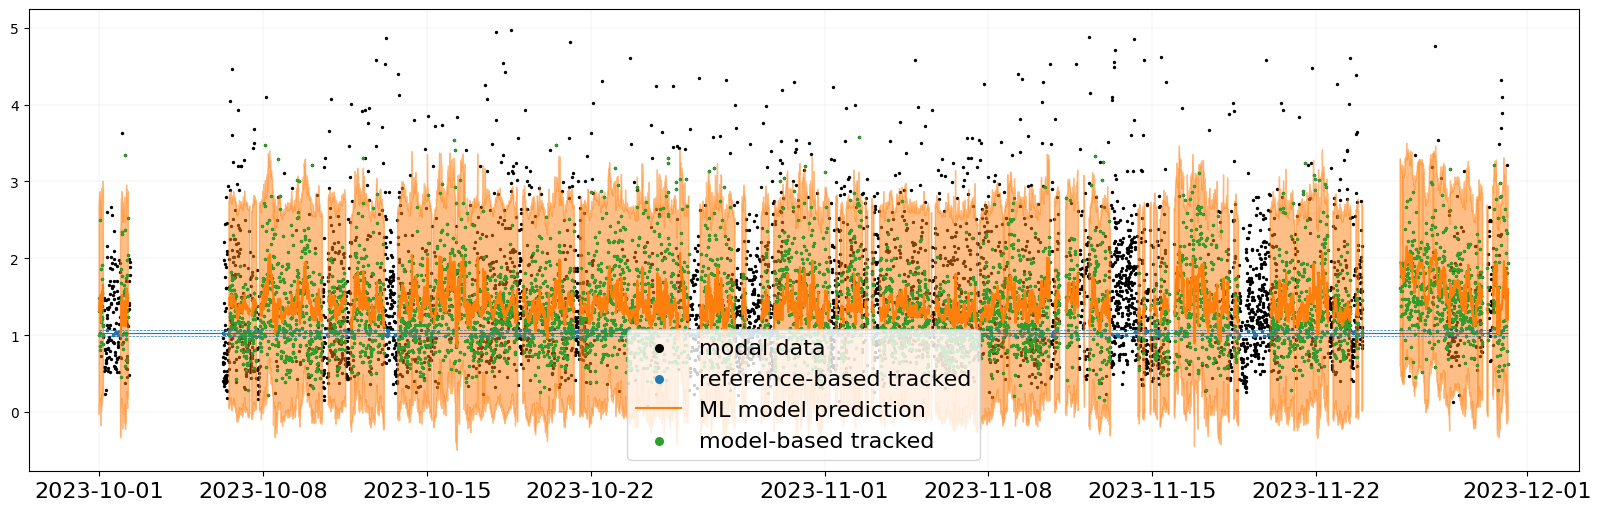

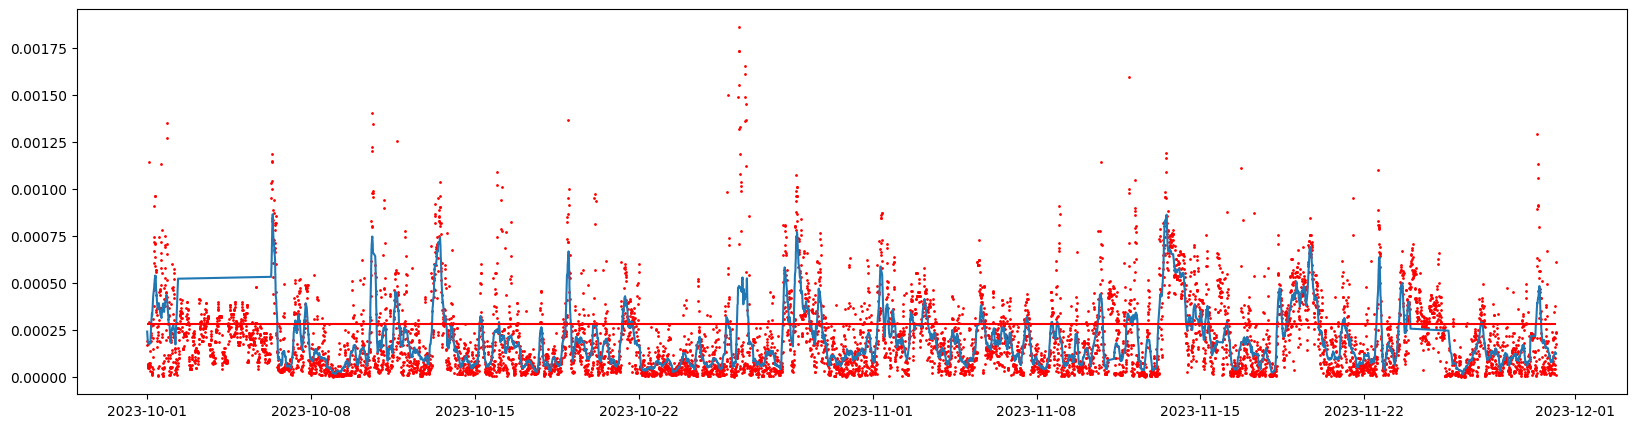

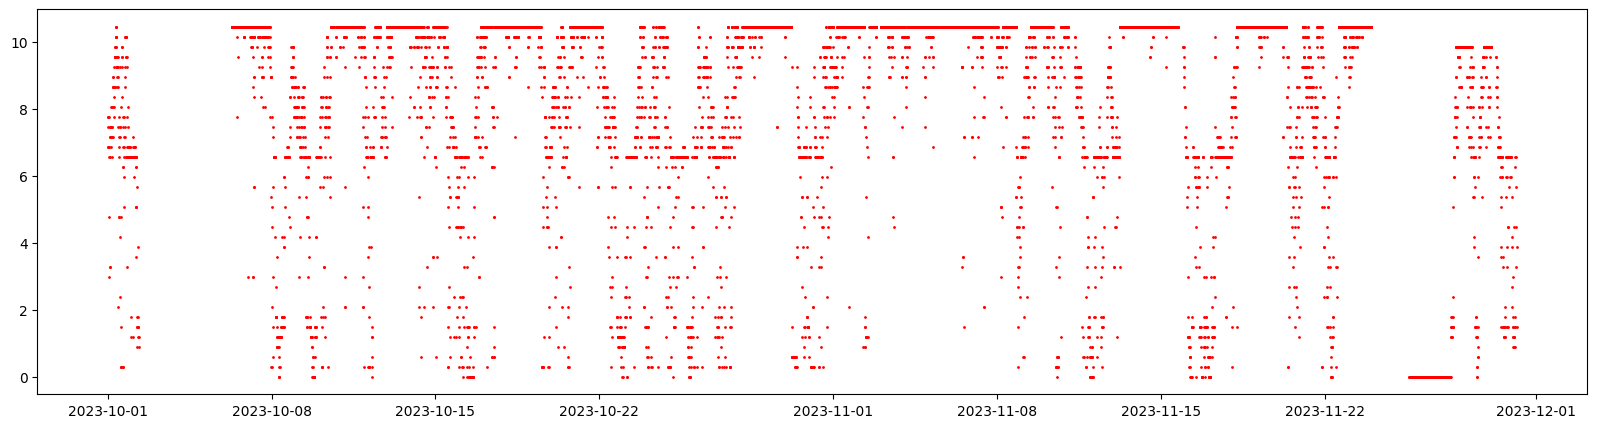

In [44]:
analyzed_timeframe = (
    datetime.datetime(2023, 10, 1, tzinfo=datetime.timezone.utc),
    datetime.datetime(2023, 11, 30,5, tzinfo=datetime.timezone.utc)
)
#prediction_lim = np.abs((y - predictions_df['prediction']).loc[X_train.index]).quantile(0.99)
prediction_lim = (y - cat_pred_df['prediction']).loc[X_train.index].std()*2

plt_selected_input_data = X.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
plt_modal_data = y.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
plt_predictions = cat_pred_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
low_uncertainty = uncertainty_[uncertainty_moving_avg < uncertainty_lim].index
common_indices = plt_predictions.index.intersection(low_uncertainty)
plt_predictions_low_uncertainty = plt_predictions.loc[common_indices]
resampled_plt_predictions = plt_predictions_low_uncertainty.resample('10T').asfreq()['prediction']
resampled_plt_predictions.interpolate(method='linear', inplace=True, limit_direction='both', limit=2)
plt_smart_tracked = smart_tracked_modes.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]

upper_ref = 1.07
lower_ref = 0.99
reference_tracked = plt_modal_data[(plt_modal_data > lower_ref) & (plt_modal_data < upper_ref)]

plt.figure(figsize=(20, 6))
plt.scatter(plt_modal_data.index, plt_modal_data, color='k', s=2, label='modal data')
plt.hlines(upper_ref, analyzed_timeframe[0], analyzed_timeframe[1], color='tab:blue', linewidth=0.5, linestyle='--')
plt.hlines(lower_ref, analyzed_timeframe[0], analyzed_timeframe[1], color='tab:blue', linewidth=0.5, linestyle='--')
plt.hlines((lower_ref+upper_ref)/2 , analyzed_timeframe[0], analyzed_timeframe[1], color='tab:blue', linewidth=0.8)
plt.scatter(reference_tracked.index, reference_tracked, color='tab:blue', s=2, label='reference-based tracked')
#plt.plot(plt_predictions['prediction'])
#plt.scatter(plt_predictions.index, plt_predictions['prediction'], color='tab:orange', s=1)
#plt.scatter(plt_predictions_low_uncertainty.index, plt_predictions_low_uncertainty['prediction'], color='tab:blue', s=10)
plt.plot(resampled_plt_predictions, color='tab:orange', label='ML model prediction')
plt.fill_between(resampled_plt_predictions.index, resampled_plt_predictions-prediction_lim, resampled_plt_predictions+prediction_lim, alpha=0.5, color='tab:orange')

plt.scatter(plt_smart_tracked.index, plt_smart_tracked['mean_damping'], color='tab:green', s=2, label='model-based tracked')

legend = plt.legend(loc='lower center', fontsize=16)
for handles in legend.legendHandles:
    try:
        handles.set_sizes([30.0])
    except:
        pass
plt.xticks(fontsize=16)
plt.grid(linewidth=0.1)
plt.show()
plt.close()

plt.figure(figsize=(20,5))
plt.plot(uncertainty_moving_avg.loc[analyzed_timeframe[0]:analyzed_timeframe[1]])
plt.hlines(uncertainty_lim, analyzed_timeframe[0], analyzed_timeframe[1], color='r')
plt.scatter(cat_pred_virtual_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]].index, cat_pred_virtual_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]['knowledge_uncertainty'], s=1, c='r')
plt.show()
plt.close()
plt.figure(figsize=(20,5))
plt.scatter(plt_selected_input_data.index, plt_selected_input_data['mean_NW2_C02_rpm'], s=1, c='r')
plt.show()
plt.close()